Can we create a model to predict the opening weekend box office success of a movie using tweets? Theoretically, it seems like it should be possible. A lot of people tweeting about a movie should indicate that it will be successful. Practically, is it possible to abstract meaning from data that is seemingly so noisy?

It seems daunting considering that with a simple strategy there will be plenty of instances where tweets are considered that are not even about the movie in question. For example, when you search for the movie 'Wild (2014)', you get some results like this: 

I was undaunted by this challenge and dove straight in. In the end, without doing anything too sophisticated, I was able to produce a fairly decent model.

### Obtaining the Box Office Data

I obtained data from boxofficemojo.com using the requests library and parsed it using BeautifulSoup4. I specifically worked with [this](http://www.boxofficemojo.com/alltime/weekends/) data which is all Domestic (U.S.) movies which have revenue data for a Friday-Saturday-Sunday opening weekends. I grabbed the first 1000 from this list sorted by date with recent first. I made this decision based on the [fact](http://www.internetlivestats.com/twitter-statistics/) that Twitter's popularity has grown extreemly rapidly. I made the judgment that by around late 2009 there were been enough tweets to predict the success of a movie.

### Obtaining the Twitter Data

I used Selenium to crawl [Twitter's Advanced Search Engine](https://twitter.com/search-advanced) and get the data. Using the API was out of the questions since the API only has tweets from the last 7 days. Scraping was a challenge because of the 'infinite scroll' feature of this site.

I used the 'This exact phrase' box for searching. Also, I did a little processing to the movies' titles. To avoid penalizing movies with long titles I stripped all years in parenthesis and subtitles. So for "Precious: Based on the Novel 'Push' by Sapphire" I searched for 'Precious'.


Because of time and resourse contraints (still working on my Linux skills for AWS) I constrained my data to tweets from the week before the opening of the movie. 

If I made one search for each movie with the date range set to the whole week, I typically obtained a never ending stream of tweets from the first couple days before the opening. To try to capture the difference in volume of tweets across movies, I did 7 seperate searches - a day is as granular of a window you can search for - and told Selenium to scroll down the page at most 25 times for each search.

I ended up collecting data for 826 of the 1000 movies that I pulled from boxofficemojo.

### A little cleaning

I want to focus on the modeling decisions with this post so I will skip to the point in which I aggregated all the data into one nice looking csv file.

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

In [2]:
data = pd.read_csv('./../data/TwitterMovies/all_the_data.csv')

In [3]:
data.shape

(826, 7)

Most recent data point:

In [4]:
data.head(1)

,title,opening_wknd,opening_date,Num_Tweets,Retweets,Likes,Text
0,The Legend of Tarzan,38527856,2016-07-01,1850,1-5-4-4-2-1-2-1-1-4-2-1-1-3-1-1-1-1-2-1-2-1-3-...,5-7-3-3-4-4-2-1-1-1-6-12-2-1-2-7-1-1-1-1-4-1-1...,Yelp Night at the Movies: The Legend of Tarzan...


Least recent data point:

In [5]:
data.tail(1)

,title,opening_wknd,opening_date,Num_Tweets,Retweets,Likes,Text
825,Where the Wild Things Are,32695407,2009-10-16,3127,1-9,3-1-1-1-1-1-1-3-5-1-3-1-1-1-2-3-1-1-1-3-1-2-98...,"Notes From Mymix: Where the Wild Things Are, J..."


What the hell are all those columns you might ask. Well opening_wknd is the opening weekend gross which has not been adjusted for inflation. Retweets is currently a string that has the number of Retweets for each tweet that had *any* Retweets joined with a dash. Likes is the same except for Likes. And Text is a massive document of text from all the tweets that were obtained about the particular movie.

Here's a sample of text:

In [6]:
data.iloc[0].Text[0:150]

'Yelp Night at the Movies: The Legend of Tarzan RSVP on the Yelp event page to get tickets  http://ift.tt/28SVLUnpic.twitter.com/7e7XUEMEho New video I'

Number of characters in this particular document:

In [7]:
len(data.iloc[0].Text)

225296

Alright, now, let's get the boring stuff out of the way. Let's get the Retweets and Likes into a more usable form.

In [8]:
import re

In [9]:
pattern = '[0-9]'
regex = re.compile(pattern)

In [10]:
data.Retweets = [[0]*(num_tweets-len([c for c in str(ret) if re.match(regex,c)])) + map(int,[c for c in str(ret) if re.match(regex,c)]) for ret,num_tweets in zip(data.Retweets,data.Num_Tweets)]

In [11]:
data.Likes = [[0]*(num_tweets-len([c for c in str(lik) if re.match(regex,c)])) + map(int,[c for c in str(lik) if re.match(regex,c)]) for lik,num_tweets in zip(data.Likes,data.Num_Tweets)]

In [12]:
data.head(1)

,title,opening_wknd,opening_date,Num_Tweets,Retweets,Likes,Text
0,The Legend of Tarzan,38527856,2016-07-01,1850,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Yelp Night at the Movies: The Legend of Tarzan...


Now let's purge the Text data of all links and Twitter handles.

In [13]:
def cleanse_doc(doc):
    return ' '.join([word for word in doc.split() 
                     if 'http://' not in word and 'www.' not in word
                     and '@' not in word and 'https://' not in word
                     and '.com' not in word and '.net' not in word])

In [14]:
data.Text = [cleanse_doc(doc) for doc in data.Text]

In [15]:
data.iloc[0].Text[0:150]

'Yelp Night at the Movies: The Legend of Tarzan RSVP on the Yelp event page to get tickets New video Interviews with Alexander Skarsgrd & the stars of '

One more boring but necessary step: adjust the revenue numbers for inflation. Since I have less than 7 years of data, I make the simplifying assumption that there has been a constant rate of inflation of this period (12% in total).

In [16]:
from datetime import date

In [17]:
def inflation_adjuster(dates,gross):
    inf_rate = .12/7.0
    dates = [date(*map(int,d.split('-'))) for d in dates]
    base = min(dates)
    today = max(dates)
    return [g * (1+inf_rate)**((today-base).days/365.0) / \
     (1+inf_rate)**((d-base).days/365.0) for d,g in zip(dates,gross)]

In [18]:
data.opening_wknd = inflation_adjuster(data.opening_date,data.opening_wknd)

In [19]:
data.tail(1)

,title,opening_wknd,opening_date,Num_Tweets,Retweets,Likes,Text
825,Where the Wild Things Are,3.664687e+07,2009-10-16,3127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Notes From Mymix: Where the Wild Things Are, J..."


### Feature Engineering

Since the volume of Twitter data has increased so much during the last 7 years, including the time as a feature and looking at interactions will be essential.

In [20]:
data.insert(1,'days from today',[(date(2016,7,15) - date(*map(int,d.split('-')))).days for d in data.opening_date])

In [21]:
data.head(1)

,title,days from today,opening_wknd,opening_date,Num_Tweets,Retweets,Likes,Text
0,The Legend of Tarzan,14,38527856.0,2016-07-01,1850,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Yelp Night at the Movies: The Legend of Tarzan...


Now, I don't quite know what summary statistics of the Retweets and Likes I should include. So, I'll just include a whole bunch and allow my model to do this work for me.

In [22]:
import numpy as np

In [23]:
def trimmed_mean(t):
    t = np.array(t)
    iqr = np.percentile(t,75) - np.percentile(t,25)
    med = np.median(t)
    t = t[np.where((t>=(med-1.5*iqr)) & (t<=(med+1.5*iqr)))]
    return np.mean(t)

In [24]:
data.insert(5,'Total_Retweets',[sum(ret) for ret in data.Retweets])
data.insert(6,'Median_Retweets',[np.median(ret) for ret in data.Retweets])
data.insert(7,'Mean_Retweets',data.Total_Retweets/data.Num_Tweets)
data.insert(8,'Trimmed_Mean_Retweets',[trimmed_mean(ret) for ret in data.Retweets])
data.insert(9,'90th_Percentile_Retweets',[np.percentile(ret,90) for ret in data.Retweets])
data.insert(10,'95th_Percentile_Retweets',[np.percentile(ret,95) for ret in data.Retweets])
data.insert(11,'98th_Percentile_Retweets',[np.percentile(ret,98) for ret in data.Retweets])
data.insert(12,'99th_Percentile_Retweets',[np.percentile(ret,99) for ret in data.Retweets])
data.insert(13,'99.5th_Percentile_Retweets',[np.percentile(ret,99.5) for ret in data.Retweets])
data.insert(14,'Max_Retweets',[max(ret) for ret in data.Retweets])

In [25]:
data.insert(16,'Total_Likes',[sum(lik) for lik in data.Likes])
data.insert(17,'Median_Likes',[np.median(lik) for lik in data.Likes])
data.insert(18,'Mean_Likes',data.Total_Likes/data.Num_Tweets)
data.insert(19,'Trimmed_Mean_Likes',[trimmed_mean(lik) for lik in data.Likes])
data.insert(20,'90th_Percentile_Likes',[np.percentile(lik,90) for lik in data.Likes])
data.insert(21,'95th_Percentile_Likes',[np.percentile(lik,95) for lik in data.Likes])
data.insert(22,'98th_Percentile_Likes',[np.percentile(lik,98) for lik in data.Likes])
data.insert(23,'99th_Percentile_Likes',[np.percentile(lik,99) for lik in data.Likes])
data.insert(24,'99.5th_Percentile_Likes',[np.percentile(lik,99.5) for lik in data.Likes])
data.insert(25,'Max_Likes',[max(lik) for lik in data.Likes])

In [26]:
data.head(1)

,title,days from today,opening_wknd,opening_date,Num_Tweets,Total_Retweets,Median_Retweets,Mean_Retweets,Trimmed_Mean_Retweets,90th_Percentile_Retweets,95th_Percentile_Retweets,98th_Percentile_Retweets,99th_Percentile_Retweets,99.5th_Percentile_Retweets,Max_Retweets,Retweets,Total_Likes,Median_Likes,Mean_Likes,Trimmed_Mean_Likes,90th_Percentile_Likes,95th_Percentile_Likes,98th_Percentile_Likes,99th_Percentile_Likes,99.5th_Percentile_Likes,Max_Likes,Likes,Text
0,The Legend of Tarzan,14,38527856.0,2016-07-01,1850,696,0.0,0.376216,0.0,1.0,2.0,4.0,6.0,8.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1427,0.0,0.771351,0.200129,2.0,4.0,7.0,8.0,8.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Yelp Night at the Movies: The Legend of Tarzan...


Now I'll use sklearn's TfidfVectorizer to convert my documents into text frequencies. I will use n-grams of lengths one, two, and three. In order to filter out some noise, I'm going to specify that for a feature to be made, the word or phrase must have been in at least 20% of the documents.

Also, from previous iterations, I learned that it is a good idea to tokenize the titles of the movies and include these tokens as stop words. The reason being that words that are in the titles of movies are considered to be some of the most important features in the Tf-idf world and including these words as features will make it more difficult for a model to pick out the truly generalizable word features.

If a token from the titles appears in at least 10% of the titles, I will allow it to be a feature. If not, it will be a stop word.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [28]:
titles = [title.lower() for title in data.title]

In [29]:
tfidf_titles = TfidfVectorizer(use_idf=True,stop_words=None,ngram_range=(1,3),max_df=.10)

In [30]:
tfidf_titles.fit_transform(titles);

In [31]:
stop_words = tfidf_titles.get_feature_names() + titles + list(ENGLISH_STOP_WORDS)
tfidf = TfidfVectorizer(use_idf=True,stop_words=stop_words,ngram_range=(1,3),min_df=.20)

In [32]:
X_text = tfidf.fit_transform(data.Text).toarray()

In [33]:
X_text.shape

(826, 4089)

I'll save the names of the text features for later.

In [34]:
d = tfidf.get_feature_names()

### Modeling with just the Summary Statistics

The first step will be to split the data into a train and test set. I'll use a 70%, 30% train, test split.

In [35]:
np.random.seed(200)
train_inds = np.random.choice(range(len(data)),int(.7*len(data)),replace=False)
test_inds = [i for i in range(len(data)) if i not in train_inds]

In [36]:
y_train, y_test = data.opening_wknd[train_inds], data.opening_wknd[test_inds]

In [37]:
print 'Length of Training Set: %d.' % len(y_train),'Length of Test Set: %d.' % len(y_test)

Length of Training Set: 578. Length of Test Set: 248.


Since I have a suspicion that some of my features might be redundant, I'll use the Lasso to encourage sparcity.

In [38]:
from sklearn.linear_model import LassoCV

In [39]:
lcv = LassoCV(n_alphas=100, fit_intercept=True, normalize=True, max_iter=1e7, cv=50, n_jobs=-1, random_state=3)

In [40]:
summary_stat_feature_inds = [1] + range(4,15) + range(16,26)
X_summary_stat = data.iloc[:,summary_stat_feature_inds]

In [41]:
X_summary_stat.head(3)

,days from today,Num_Tweets,Total_Retweets,Median_Retweets,Mean_Retweets,Trimmed_Mean_Retweets,90th_Percentile_Retweets,95th_Percentile_Retweets,98th_Percentile_Retweets,99th_Percentile_Retweets,99.5th_Percentile_Retweets,Max_Retweets,Total_Likes,Median_Likes,Mean_Likes,Trimmed_Mean_Likes,90th_Percentile_Likes,95th_Percentile_Likes,98th_Percentile_Likes,99th_Percentile_Likes,99.5th_Percentile_Likes,Max_Likes
0,14,1850,696,0.0,0.376216,0.000000,1.0,2.0,4.0,6.0,8.0,9,1427,0.0,0.771351,0.200129,2.0,4.0,7.0,8.0,8.0,9
1,14,2831,2226,0.0,0.786295,0.171285,3.0,5.0,7.0,8.0,9.0,9,3048,0.0,1.076651,0.298001,3.0,5.0,7.0,8.0,9.0,9
2,14,2412,1096,0.0,0.454395,0.000000,1.0,3.0,5.0,7.0,8.0,9,4565,1.0,1.892620,1.446942,5.0,6.0,8.0,9.0,9.0,9


In [42]:
X_summary_stat.shape

(826, 22)

In [43]:
lcv.fit(X_summary_stat.iloc[train_inds,:],y_train);

Let's take a look at how many of the 22 features have non-zero coefficients.

In [44]:
np.sum(lcv.coef_!=0)

8

Now how did the model perform? Let's look at the model's R-squared using the mean MSE across the 50 folds for the optimal choice of alpha.

In [45]:
1 - lcv.mse_path_.mean(1).min()/np.var(y_train)

0.11771850709355025

Now let's visualize how this model did. 

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

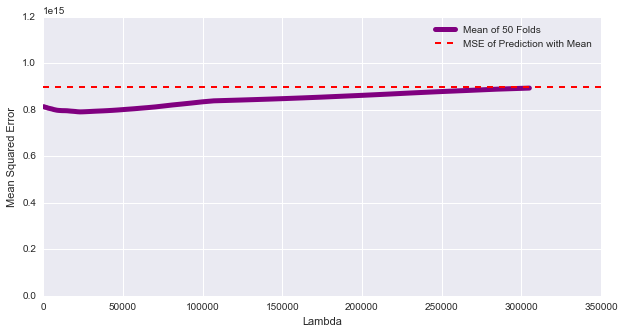

In [47]:
plt.figure(figsize=(10,5))
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1),lw=5,c='purple',label='Mean of 50 Folds');
plt.axhline(np.var(y_train),label='MSE of Prediction with Mean',lw=2,ls='--',c='r');
plt.legend();
plt.ylim(0,12e14);
plt.ylabel('Mean Squared Error');
plt.xlabel('Lambda');

This model performed slightly better than using the mean as a predictor. Since we know that at least the interaction between volume of tweets and likes and retweets with the time feature should be predictive, let's try adding linear interaction terms.

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [50]:
X_summary_stat = poly.fit_transform(X_summary_stat)

In [51]:
X_summary_stat.shape

(826, 253)

In [52]:
lcv.fit(X_summary_stat[train_inds],y_train);

How many of the 253 features have non-zero coefficents?

In [53]:
sum(lcv.coef_!=0)

7

Let's see if the R-squared is any better.

In [54]:
1 - lcv.mse_path_.mean(1).min()/np.var(y_train)

0.13771806743735238

It is. And the graph..

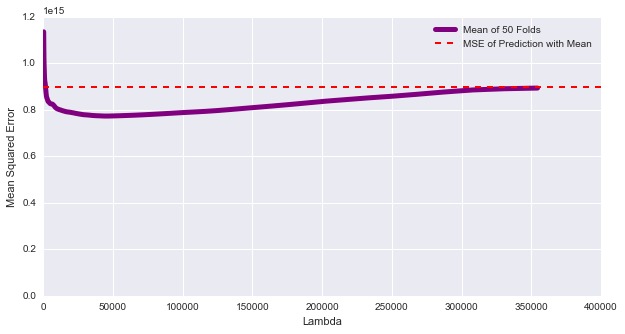

In [55]:
plt.figure(figsize=(10,5))
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1),lw=5,c='purple',label='Mean of 50 Folds');
plt.axhline(np.var(y_train),label='MSE of Prediction with Mean',lw=2,ls='--',c='r');
plt.legend();
plt.ylim(0,12e14);
plt.ylabel('Mean Squared Error');
plt.xlabel('Lambda');

### Modeling with just the Text Features

In [56]:
lcv.fit(X_text[train_inds],y_train);

How many non-zero features?

In [57]:
sum(lcv.coef_!=0)

119

R-Squared?

In [58]:
1 - lcv.mse_path_.mean(1).min()/np.var(y_train)

0.43187996128967576

What are the most predictive features?

In [59]:
for ind in np.argsort(np.abs(lcv.coef_))[::-1][0:10]:
    print d[ind],lcv.coef_[ind]

tickets friday 1049465338.44
hype 844177671.028
hyped 561438378.895
cinemark 463055207.729
friday gonna 344785402.099
rt review 317181426.344
suit 310879384.146
thinking seeing -302743421.329
jealous 300799774.119
talented -295114897.969


### Putting the Two Sets of Features Together

I do not want to take only the pre-selected features from the previous models and then run a model with just those features since that is one of the classic over-fitting pitfalls. Instead I will just run a single lasso with both sets of features.

In order to implement this strategy while avoiding overfitting, feature-selection would need to happen inside each fold of cross-validation. This seems beyond the scope of a simple post so I will not do this here.

In [60]:
X = np.hstack((X_summary_stat,X_text))

In [61]:
lcv.fit(X[train_inds],y_train);

Number of non-zero features?

In [62]:
sum(lcv.coef_!=0)

126

R-Squared?

In [63]:
1 - lcv.mse_path_.mean(1).min()/np.var(y_train)

0.4307676030817309

Interestingly, the r-squared went down a tiny bit when I included the summary stat features. 

### Testing

I will end by simply predicting the hold-out movies, computing the R-Squared of the prediction and visualizing 50 of the predictions.

In [64]:
lcv.score(X[test_inds],y_test)

0.52091228171743031

Not bad!

In [65]:
predictions = lcv.predict(X[test_inds])

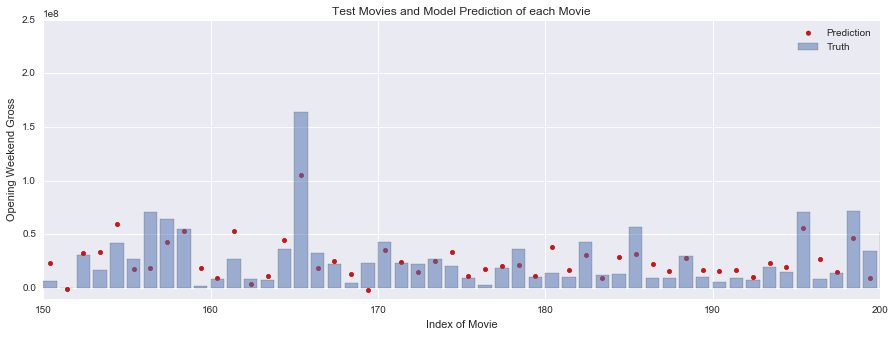

In [66]:
plt.figure(figsize=(15,5))
plt.bar(range(len(y_test)),y_test,alpha=.5,label='Truth');
plt.scatter(np.array(range(len(y_test)))+.4,predictions,c='r',label='Prediction')
plt.xlim(150,200);
plt.ylim(-.1e8)
plt.legend();
plt.ylabel('Opening Weekend Gross');
plt.xlabel('Index of Movie');
plt.title('Test Movies and Model Prediction of each Movie');

### Conclusion

I believe I have demonstrated that Twitter can be a rich data source for predicting movies' success. Making this model better could be done by collecting more data - i.e. going further back than 7 days before the opening, and scrolling down more than 25 times for each search. I wonder if what was holding back the summary statistic features from being predictive was the small amount of data that was collected.

As for the text features, a simple improvement might be to add as stop words any words that are too specific to a few movies but are not in the titles of the movies - i.e. 'Bond'. A more complicated improvement might be to try to decipher whether a tweet is about the movie in question on a tweet by tweet basis.

More generally, I think I have shown that data from Twitter can definetly have predictive value.

### Bonus material

Just for fun, let's fit a model to the whole data set and see the 20 text features with the largest positive coefficients, and the 20 with the largest negative coefficients. 

In [67]:
lcv.fit(X_text,data.opening_wknd);

Top 20 positive features:

In [68]:
print ', '.join([d[ind] for ind in np.argsort(lcv.coef_)[::-1][0:20]])

hype, tickets friday, rt review, cinemark, jealous, premiere thursday, hyped, friday gonna, posts, waiting line, toys, booked, premiere carpet, counting days, arriving, premier, glasses, suit, excitement, fitting


Top 20 negative features:

In [69]:
print ', '.join([d[ind] for ind in np.argsort(lcv.coef_)[0:20]])

thinking seeing, talented, york ny, unfortunately, really liked, los angeles ca, heard, embarrassing, titled, gonna try, depressing, awe, movies opening, charity, hug, grateful, played, email, near, weeks ago
